# Reinforcement Learning


##Monte Carlo Simulation#

Episode 0: Policy Effectiveness = 99.65
Episode 100: Policy Effectiveness = 11.83
Episode 200: Policy Effectiveness = 13.89
Episode 300: Policy Effectiveness = 11.9
Episode 400: Policy Effectiveness = 11.48
Episode 500: Policy Effectiveness = 10.92
Episode 600: Policy Effectiveness = 11.25
Episode 700: Policy Effectiveness = 12.17
Episode 800: Policy Effectiveness = 16.48
Episode 900: Policy Effectiveness = 10.67
Episode 1000: Policy Effectiveness = 11.77
Episode 1100: Policy Effectiveness = 12.04
Episode 1200: Policy Effectiveness = 11.9
Episode 1300: Policy Effectiveness = 11.66
Episode 1400: Policy Effectiveness = 11.47
Episode 1500: Policy Effectiveness = 11.45
Episode 1600: Policy Effectiveness = 12.06
Episode 1700: Policy Effectiveness = 11.81
Episode 1800: Policy Effectiveness = 11.23
Episode 1900: Policy Effectiveness = 11.77
Episode 2000: Policy Effectiveness = 13.81
Episode 2100: Policy Effectiveness = 11.58
Episode 2200: Policy Effectiveness = 12.56
Episode 2300: Policy Effe

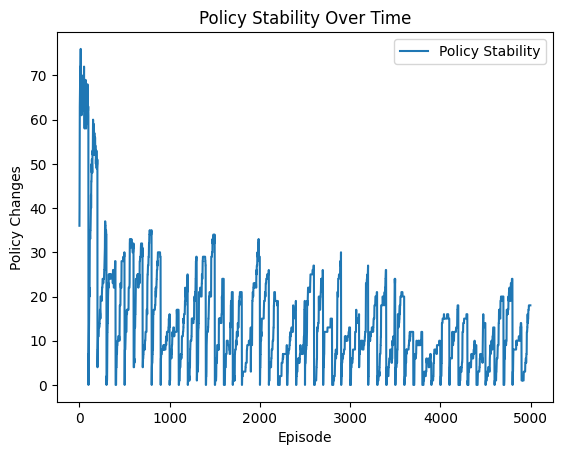

Final Policy Effectiveness (Average Steps to Goal): 11.6


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Constants
NUM_SQUARES = 101  # Total number of squares on the game board (0 to 100)
DICE = {
    "RED": [2, 2, 2, 2, 6, 6],
    "BLUE": [3, 3, 3, 3, 3, 3],
    "GREEN": [1, 1, 1, 5, 5, 5],
    "BLACK": [0, 0, 4, 4, 4, 4],
}
GAMMA = 0.9  # Discount factor for future rewards
ALPHA = 0.2  # Learning rate
EPSILON = 0.1  # Exploration factor for epsilon-greedy policy
EPISODES = 5000  # Number of episodes for training
MAX_TRAJECTORY_LENGTH = 500  # Maximum allowed trajectory length to avoid infinite loops


# Chutes and Ladders mapping
chutes_ladders = {
    1: 38, 4: 14, 9: 31, 16: 6, 21: 42, 28: 84, 36: 44,
    48: 26, 49: 11, 51: 67, 56: 53, 62: 19, 64: 60,
    71: 91, 80: 100, 87: 24, 93: 73, 95: 75, 98: 78
}

def update(state, action):
    """
    Simulates a state transition based on the chosen dice action.

    Parameters:
        state (int): The current position on the board.
        action (int): The selected dice (0: RED, 1: BLUE, 2: GREEN, 3: BLACK).

    Returns:
        tuple: (next_state, reward)
            next_state (int): The updated state after applying dice roll and chutes/ladders.
            reward (int): Reward for the transition (-1 for each step, 0 for reaching the goal).
    """
    dice = [
        np.array(DICE["RED"]),
        np.array(DICE["BLUE"]),
        np.array(DICE["GREEN"]),
        np.array(DICE["BLACK"])
    ]

    # Roll the dice and compute the next position
    new = state + np.random.choice(dice[action])
    new = chutes_ladders.get(new, new)  # Apply chutes and ladders transitions

    # Check if the player reaches or exceeds the goal state
    if new >= NUM_SQUARES - 1:
        return NUM_SQUARES - 1, 0  # Terminal state, no further penalty

    return new, -1  # Default step reward

def epsilon_greedy_policy(state, Q):
    """
    Selects an action using the epsilon-greedy strategy.

    Parameters:
        state (int): The current position on the board.
        Q (dict): State-action value table (Q-values).

    Returns:
        int: The selected action (0: RED, 1: BLUE, 2: GREEN, 3: BLACK).
    """
    if np.random.rand() < EPSILON:
        return np.random.choice(range(4))  # Random action (exploration)
    return max(Q[state], key=Q[state].get)  # Best action (exploitation)

def evaluate_policy(policy, num_episodes=100):
    """
    Evaluates the effectiveness of a policy by simulating episodes.

    Parameters:
        policy (dict): The policy mapping states to actions.
        num_episodes (int): Number of episodes to simulate for evaluation.

    Returns:
        float: The average number of steps required to reach the goal.
    """
    total_steps = 0
    for _ in range(num_episodes):
        state = 0
        steps = 0
        while state != NUM_SQUARES - 1 and steps < MAX_TRAJECTORY_LENGTH:
            action = policy[state]  # Follow the current policy
            state, _ = update(state, action)  # Transition to next state
            steps += 1
        total_steps += steps
    return total_steps / num_episodes

def monte_carlo_control_with_snapshots():
    """
    Implements Monte Carlo control with policy snapshots for analysis.

    Returns:
        tuple: (policy, Q, policy_stability)
            policy (dict): The final policy mapping states to optimal actions.
            Q (dict): Final state-action value table.
            policy_stability (list): Number of policy changes per episode.
    """
    # Initialize Q-values and random policy
    Q = defaultdict(lambda: {action: 0 for action in range(4)})
    policy = {state: np.random.choice(range(4)) for state in range(NUM_SQUARES)}
    policy_stability = []
    snapshots = {}

    for episode in range(EPISODES):
        state = 0
        trajectory = []

        # Generate a trajectory for the current episode
        for _ in range(MAX_TRAJECTORY_LENGTH):
            action = epsilon_greedy_policy(state, Q)
            next_state, reward = update(state, action)
            trajectory.append((state, action, reward))
            state = next_state
            if state == NUM_SQUARES - 1:  # Terminal state reached
                break

        # Monte Carlo return and Q-value updates
        G = 0
        returns = set()
        for state, action, reward in reversed(trajectory):
            G = reward + GAMMA * G  # Discounted return
            if (state, action) not in returns:  # First-visit MC
                returns.add((state, action))
                Q[state][action] += ALPHA * (G - Q[state][action])  # Update Q-value

        # Policy improvement
        for state in range(NUM_SQUARES):
            policy[state] = max(Q[state], key=Q[state].get)  # Choose best action

        # Record policy stability
        if episode > 0:
            changes = sum(1 for s in policy if policy[s] != snapshots.get(s, -1))
            policy_stability.append(changes)

        # Save policy snapshot every 100 episodes
        if episode % 100 == 0:
            snapshots = policy.copy()
            effectiveness = evaluate_policy(policy)
            print(f"Episode {episode}: Policy Effectiveness = {effectiveness}")

    return policy, Q, policy_stability

# Run Monte Carlo control with snapshots
policy, Q, policy_stability = monte_carlo_control_with_snapshots()

# Visualize policy stability
plt.plot(policy_stability, label="Policy Stability")
plt.xlabel("Episode")
plt.ylabel("Policy Changes")
plt.title("Policy Stability Over Time")
plt.legend()
plt.show()

# Final policy evaluation
effectiveness = evaluate_policy(policy)
print("Final Policy Effectiveness (Average Steps to Goal):", effectiveness)


##Temporal Difference Algorithms#


In [ ]:
# dice:
# 1- Red
# 2- Blue
# 3- Green
# 4- Black

def pretty_print (Q,V,P):

    # V
    print('State Values')
    for i in range(10):
        print('{0:4.1f}  '.format(V[i]),end='')
    print()
    for i in range(10,20):
        print('{0:4.1f}  '.format(V[i]),end='')
    print()
    for i in range(20,30):
        print('{0:4.1f}  '.format(V[i]),end='')
    print()
    for i in range(30,40):
        print('{0:4.1f}  '.format(V[i]),end='')
    print()
    for i in range(40,50):
        print('{0:4.1f}  '.format(V[i]),end='')
    print()
    for i in range(50,60):
        print('{0:4.1f}  '.format(V[i]),end='')
    print()
    for i in range(60,70):
        print('{0:4.1f}  '.format(V[i]),end='')
    print()
    for i in range(70,80):
        print('{0:4.1f}  '.format(V[i]),end='')
    print()
    for i in range(80,90):
        print('{0:4.1f}  '.format(V[i]),end='')
    print()
    for i in range(90,100):
        print('{0:4.1f}  '.format(V[i]),end='')
    print()

    convert = {0:'RED', 1:'BLUE', 2:'GREEN', 3:'BLACK'}
    # P
    print('\nPolicy')
    for i in range(10):
        print(' {0:4s} '.format(convert[P[i]]),end='')
    print()
    for i in range(10,20):
        print(' {0:4s} '.format(convert[P[i]]),end='')
    print()
    for i in range(20,30):
        print(' {0:4s} '.format(convert[P[i]]),end='')
    print()
    for i in range(30,40):
        print(' {0:4s} '.format(convert[P[i]]),end='')
    print()
    for i in range(40,50):
        print(' {0:4s} '.format(convert[P[i]]),end='')
    print()
    for i in range(50,60):
        print(' {0:4s} '.format(convert[P[i]]),end='')
    print()
    for i in range(60,70):
        print(' {0:4s} '.format(convert[P[i]]),end='')
    print()
    for i in range(70,80):
        print(' {0:4s} '.format(convert[P[i]]),end='')
    print()
    for i in range(80,90):
        print(' {0:4s} '.format(convert[P[i]]),end='')
    print()
    for i in range(90,100):
        print(' {0:4s} '.format(convert[P[i]]),end='')
    print()
    print()

    '''
    # Q
    print("Q =   ",end='')

    for a in range(4):
        print('  {0:5s}'.format(convert[a]),end='')
    print()
    for i in range(100):
        print('s[{0:d}] '.format(i),end='')
        for a in range(4):
            print('{0:5.1f}  '.format(Q[i][a]),end='')
        print()
    print()
    '''

    return


def e_greedy(s,policy,epsilon):
    '''
    Implements an e-greedy policy.
    With probability epsilon, it returns random action choice
    otherwise returns action choice specified by the policy

    s = current state
    policy = policy function (an array that is indexed by state)
    epsilon (0 to 1) a probability of picking exploratory random action
    '''
    z = np.random.random()
    if z > epsilon:
        return policy[s]
    else:
        return np.random.randint(0,4)



def init ():
    '''
    Create totals, counts and policy defaults
    '''
    Q = np.zeros((101,4))
    P = np.random.randint(0,4,size=101)
    return Q,P

def policy_improvement(Q):
    '''
    Update value function V and policy P based on Q values
    '''
    V = np.max(Q,axis=1)
    P = np.argmax(Q,axis=1)
    return V,P

def real_state(state):
    '''
    PARAMETERS:
    state - an integer 0 to 100 representing a state of the game
    RETURN VALUES:
    true value of the state, some states are not states (Chute or ladder)
    '''
    real={}

    #ladders
    real[1]=38
    real[4]=14
    real[9]=31
    real[28]=84
    real[21]=42
    real[36]=44
    real[51]=67
    real[71]=91
    real[80]=100

    #chutes
    real[16]=6
    real[47]=26
    real[49]=11
    real[56]=53
    real[62]=19
    real[64]=60
    real[87]=24
    real[93]=73
    real[95]=75
    real[98]=78

    #end
    real[101]=100
    real[102]=100
    real[103]=100
    real[104]=100
    real[105]=100
    real[106]=100


    if state in real:
        return real[state]
    else:
        return state



def update (state,action): ## Fix this
    '''
    PARAMETERS:
    state - an integer 0 to 100 representing a state of the game
    action - integer  0: red, 1: blue, 2: green, 3: black
    RETURN VALUES:
    next state (integer 0 to 100)
    reward (typically -1 to represent one more turn taken)
    '''
    red=np.array([2,2,2,2,6,6])
    blue=np.array([3,3,3,3,3,3])
    green=np.array([1,1,1,5,5,5])
    black=np.array([0,0,4,4,4,4])

    if action==0:
        new=state+np.random.choice(red)
    if action==1:
        new=state+np.random.choice(blue)
    if action==2:
        new=state+np.random.choice(green)
    if action==3:
        new=state+np.random.choice(black)

    new=real_state(new)
    reward=-1
    if state==100:
        reward=0

    return new, reward





#===============================================#
#      SARSA                                    #
#===============================================#

def SARSA (Q,policy,alpha,epsilon):
    '''
    Perform 1 unit of experience (1 trial, trajectory)
    using the SARSA learning algorithm
    '''
    CUTOFF = 250
    count = 0

    total_reward = 0

    state = 0
    action = e_greedy(state,policy,epsilon)


    while state < 100 and count < CUTOFF:
        next_state,reward = update(state,action)
        total_reward += reward
        next_action = e_greedy(next_state,policy,epsilon)
        TDerror = reward + Q[next_state,next_action] - Q[state,action]
        Q[state,action] = Q[state,action] + alpha * TDerror
        V,policy = policy_improvement(Q)
        state = next_state
        action = next_action
        count += 1


    # now we need to update last (terminal) state
    if state == 100:
        reward = 0
        target = 0
    else:
        reward = -1
        target = np.max(Q,axis=1)[state]

    total_reward += reward

    TDerror = reward + target - Q[state,action]
    Q[state,action] = Q[state,action] + alpha * TDerror

    return total_reward


def do_SARSA_trials (Q,policy,n,alpha,epsilon):
    '''
    Perform n trials of SARSA learning
    '''
    R = 0   # total reward
    for i in range(n):
        R += SARSA(Q,policy,alpha,epsilon)

    return R / n


def check_sarsa():
    Q,P = init()
    m = 10
    n = 1000
    epsilon = 0.1
    alpha = 0.1

    performances=[]

    print("SARSA:", '\n \n')

    for i in range(m):
        print("\n*** Trial {0:d} ***".format(i))
        R = do_SARSA_trials(Q,P,n,alpha,epsilon)
        V,P = policy_improvement(Q)
        print("Perf: ",R)
        performances.append(R)

        pretty_print(Q,V,P)

    return performances

#===============================================#
#      Q-Learning                               #
#===============================================#

def QLearning (Q,policy,alpha,epsilon):
    '''
    Perform 1 unit of experience (1 trial, trajectory)
    using the Q-Learning learning algorithm
    '''
    CUTOFF = 250
    count = 0

    total_reward = 0

    state = 0

    while state < 100 and count < CUTOFF:
        action = e_greedy(state,policy,epsilon)
        next_state,reward = update(state,action)
        total_reward += reward

        best_action = policy[next_state]
        TDerror = reward + Q[next_state,best_action] - Q[state,action]
        Q[state,action] = Q[state,action] + alpha * TDerror
        V,policy = policy_improvement(Q)
        state = next_state
        count += 1


    # now we need to update last (terminal) state
    if state == 100:
        reward = 0
        target = 0
    else:
        reward = -1
        target = np.max(Q,axis=1)[state]

    total_reward += reward

    TDerror = reward + target - Q[state,action]
    action = policy[state]
    Q[state,action] = Q[state,action] + alpha * TDerror

    return total_reward


def do_QLearning_trials (Q,policy,n,alpha,epsilon):
    '''
    Perform n trials of QLearning learning
    '''
    R = 0   # total reward
    for i in range(n):
        R += QLearning(Q,policy,alpha,epsilon)

    return R / n


def check_Q():
    Q,P = init()
    m = 10
    n = 1000
    epsilon = 0.1
    alpha = 0.1

    performances=[]
    print("Q LEARNING:", '\n \n')

    for i in range(m):
        print("\n*** Trial {0:d} ***".format(i))
        R = do_QLearning_trials(Q,P,n,alpha,epsilon)
        V,P = policy_improvement(Q)
        print("Perf: ",R)
        performances.append(R)

        pretty_print(Q,V,P)

    return performances


def TD():
    x=[i for i in range(10)]
    S_perf=check_sarsa()
    print('\n \n \n')
    Q_perf=check_Q()
    return x, S_perf, Q_perf

#####################adding something to test something#######
def sarsa_policy_evaluation():
    """
    Evaluate the policy using SARSA and return the optimal policy and Q-values.
    """
    Q, P = init()
    num_trials = 1000  # Number of trials per iteration
    num_iterations = 10  # Total iterations
    epsilon = 0.1
    alpha = 0.1

    for _ in range(num_iterations):
        do_SARSA_trials(Q, P, num_trials, alpha, epsilon)
    V, P = policy_improvement(Q)

    return P, V, Q


def q_learning_policy_evaluation():
    """
    Evaluate the policy using Q-Learning and return the optimal policy and Q-values.
    """
    Q, P = init()
    num_trials = 1000  # Number of trials per iteration
    num_iterations = 10  # Total iterations
    epsilon = 0.1
    alpha = 0.1

    for _ in range(num_iterations):
        do_QLearning_trials(Q, P, num_trials, alpha, epsilon)
    V, P = policy_improvement(Q)

    return P, V, Q


##Dynamic Programming

In [ ]:
import numpy.linalg as la

BOARD_SIZE = 100
DICE_COLORS = ['red', 'blue', 'green', 'black']

def create_board_transitions():
    """Create board transitions for snakes and ladders."""
    transitions = {
        # Ladders (going up)
        1: 38, 4: 14, 9: 31, 21: 42, 28: 84, 36: 44, 51: 67, 71: 91, 80: 100,

        # Snakes (going down)
        16: 6, 47: 26, 49: 11, 56: 53, 62: 19, 64: 60, 87: 24, 93: 73, 95: 75, 98: 78
    }
    return transitions

def generate_dice_probabilities():
    """generate dice probabilities for each color."""
    dice_probs = {
        'red': {0: 0.0, 1: 0.0, 2: 4/6, 3: 0.0, 4: 0.0, 5: 0.0, 6: 2/6},
        'blue': {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0, 4: 0.0, 5: 0.0, 6: 0.0},
        'green': {0: 0.0, 1: 0.5, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.5, 6: 0.0},
        'black': {0: 2/6, 1: 0.0, 2: 0.0, 3: 0.0, 4: 4/6, 5: 0.0, 6: 0.0}
    }
    return dice_probs

def compute_next_position(current_pos, roll, transitions):
    """compute the next position after a dice roll."""
    new_pos = min(current_pos + roll, BOARD_SIZE)
    return transitions.get(new_pos, new_pos)

def build_equation_matrix(policy, transitions, dice_probs):
    """build the linear equation matrix for policy iteration with regularization."""
    A = np.zeros((BOARD_SIZE + 1, BOARD_SIZE + 1))
    b = np.zeros(BOARD_SIZE + 1)

    # need to regularize parameter
    reg = 1e-10

    # last state has value = 1
    A[BOARD_SIZE, BOARD_SIZE] = 1.0 + reg

    # compute the probabilities for each state
    for state in range(BOARD_SIZE):
        current_policy_color = policy.get(state, 'red')
        probs = dice_probs[current_policy_color]

        # diagonal  = -1
        A[state, state] = -1.0 - reg

        for roll, prob in probs.items():
            if prob > 0:
                next_pos = compute_next_position(state, roll, transitions)
                A[state, next_pos] += prob

        b[state] = -1.0  # reward for taking 1 step

    return A, b

def solve_policy_value(policy, transitions, dice_probs):
    """sovle the game with given policy"""
    try:
        A, b = build_equation_matrix(policy, transitions, dice_probs)

        # Try least squares solution first
        V = la.lstsq(A, b, rcond=None)[0]

        return V[0], V
    except Exception as e:
        print(f"Error solving linear system: {e}")
        # Fallback to pseudoinverse if least squares fails
        try:
            A, b = build_equation_matrix(policy, transitions, dice_probs)
            V = la.pinv(A) @ b
            return V[0], V
        except Exception as e:
            print(f"Fallback solution failed: {e}")
            return float('inf'), np.zeros(BOARD_SIZE + 1)

def policy_iteration(initial_policy=None, max_iterations=100):
    """iterate multiple policies to find optimal policy."""
    transitions = create_board_transitions()
    dice_probs = generate_dice_probabilities()

    # start with policy 'red' dice for all states
    if initial_policy is None:
        initial_policy = {state: 'red' for state in range(BOARD_SIZE)}

    current_policy = initial_policy.copy()
    best_value, state_values = solve_policy_value(current_policy, transitions, dice_probs)

    policy_changed = True
    iterations = 0

    while policy_changed and iterations < max_iterations:
        policy_changed = False
        iterations += 1

        for state in range(BOARD_SIZE):
            best_local_value = best_value
            best_local_color = current_policy[state]

            for color in DICE_COLORS:
                # change policy for the state
                temp_policy = current_policy.copy()
                temp_policy[state] = color

                temp_value, _ = solve_policy_value(temp_policy, transitions, dice_probs)

                # update if the policy found is better
                if temp_value < best_local_value:
                    best_local_value = temp_value
                    best_local_color = color

            # update policy if a better color is found
            if best_local_color != current_policy[state]:
                current_policy[state] = best_local_color
                policy_changed = True

            # compute best value after policy changes
            best_value, state_values = solve_policy_value(current_policy, transitions, dice_probs)

    return current_policy, best_value, state_values
optimal_policy, game_value, state_values = policy_iteration()

# pretty print the results
print(f"Game value (average moves to reach goal state): {game_value}")
print("\nDice color policy and state values for each state:")
for state in range(BOARD_SIZE):
    print(f"State {state}: Color = {optimal_policy[state]}")

Game value (average moves to reach goal state): 11.416648607758793

Dice color policy and state values for each state:
State 0: Color = black
State 1: Color = black
State 2: Color = blue
State 3: Color = red
State 4: Color = blue
State 5: Color = red
State 6: Color = red
State 7: Color = blue
State 8: Color = black
State 9: Color = blue
State 10: Color = red
State 11: Color = blue
State 12: Color = black
State 13: Color = red
State 14: Color = blue
State 15: Color = green
State 16: Color = red
State 17: Color = red
State 18: Color = black
State 19: Color = blue
State 20: Color = green
State 21: Color = blue
State 22: Color = blue
State 23: Color = green
State 24: Color = black
State 25: Color = blue
State 26: Color = red
State 27: Color = black
State 28: Color = black
State 29: Color = green
State 30: Color = red
State 31: Color = red
State 32: Color = black
State 33: Color = green
State 34: Color = red
State 35: Color = blue
State 36: Color = blue
State 37: Color = red
State 38: Color

#Compare results of 4 approachs


Comparison of Algorithm Effectiveness
Monte Carlo - Average Steps to Goal: 12.12
Dynamic Programming - Average Steps to Goal: 11.416648607758793
Q-Learning - Average Steps to Goal: 10.45
SARSA - Average Steps to Goal: 11.54

Tabular Comparison of Algorithm Effectiveness:

          Algorithm  Average Steps to Goal
        Monte Carlo              12.120000
Dynamic Programming              11.416649
         Q-Learning              10.450000
              SARSA              11.540000


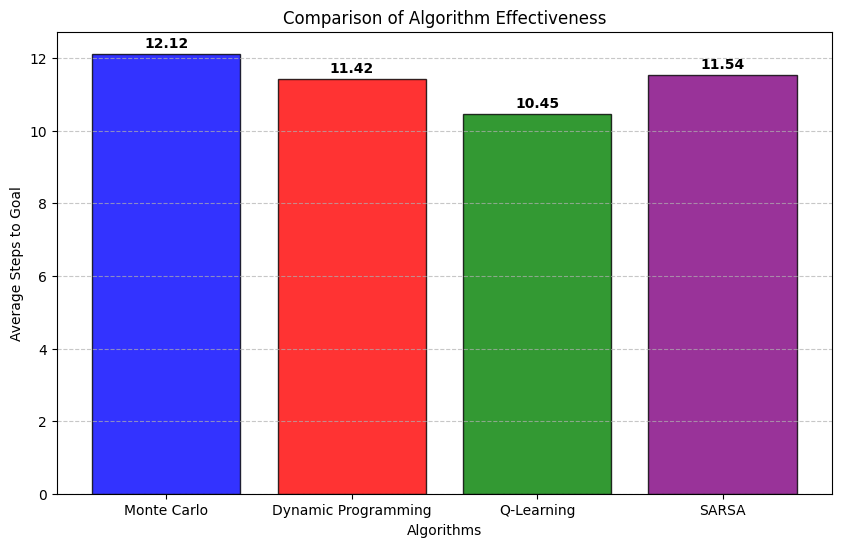

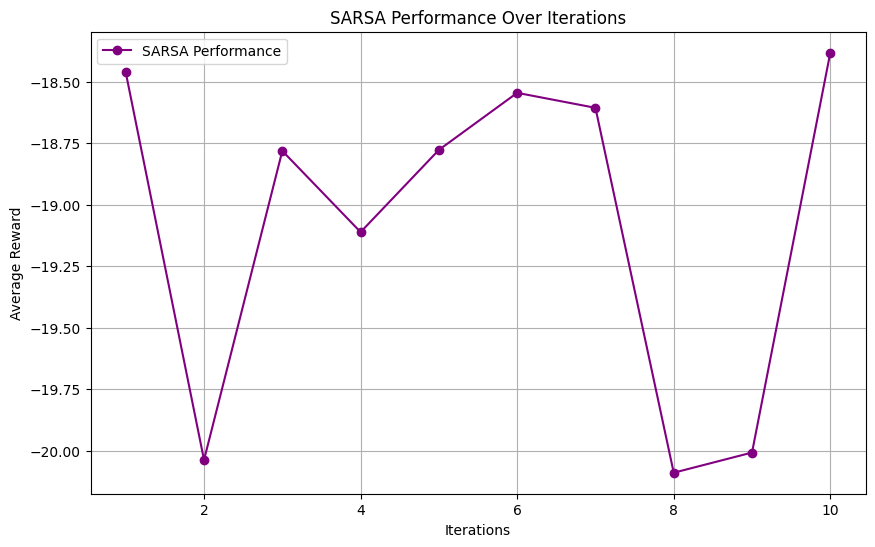

In [ ]:
import matplotlib.pyplot as plt

# Constants for Learning Algorithms
ALPHA = 0.2  # Learning rate
GAMMA = 0.9  # Discount factor
EPSILON = 0.1  # Exploration factor
EPISODES = 5000
MAX_TRAJECTORY_LENGTH = 500

def policy_evaluation(algorithm_trials, init_func, trials=1000, iterations=10, alpha=0.1, epsilon=0.1):
    """
    Perform policy evaluation for a given reinforcement learning algorithm.

    Parameters:
        algorithm_trials (function): Function that executes the learning trials.
        init_func (function): Function to initialize Q-table and policy.
        trials (int): Number of trials per iteration (default: 1000).
        iterations (int): Number of iterations to perform (default: 10).
        alpha (float): Learning rate (default: 0.1).
        epsilon (float): Exploration factor for epsilon-greedy policy (default: 0.1).

    Returns:
        tuple: (Optimal Policy, State Values, Q-Values)
    """
    Q, P = init_func()  # Initialize Q-table and policy
    for _ in range(iterations):
        algorithm_trials(Q, P, trials, alpha, epsilon)  # Run the algorithm for specified trials
    V, P = policy_improvement(Q)  # Derive state values and optimal policy
    return P, V, Q

def init():
    """    Initialize Q-table and random policy for reinforcement learning.

    Returns:
        tuple: (Initialized Q-table, Random policy)
    """
    Q = np.zeros((101, 4))  # Q-table for 101 states and 4 actions
    P = np.random.randint(0, 4, size=101)  # Randomly initialized policy
    return Q, P

def sarsa_policy_evaluation():
    """
    Evaluate policy using SARSA algorithm.

    Returns:
        tuple: (Optimal Policy, State Values, Q-Values)
    """
    return policy_evaluation(do_SARSA_trials, init)

def q_learning_policy_evaluation():
    """
    Evaluate policy using Q-Learning algorithm.

    Returns:
        tuple: (Optimal Policy, State Values, Q-Values)
    """
    return policy_evaluation(do_QLearning_trials, init)

def monte_carlo_policy_evaluation():
    """
    Evaluate the policy using Monte Carlo algorithm.

    Returns:
        tuple: (Optimal Policy, State Values, Q-Values)
    """
    Q, P = init()  # Initialize Q-table and random policy
    returns = defaultdict(list)  # Store returns for each state-action pair

    for episode in range(EPISODES):
        # Generate an episode
        state = 0
        episode_trajectory = []

        for _ in range(MAX_TRAJECTORY_LENGTH):
            action = e_greedy(state, P, EPSILON)  # Use epsilon-greedy policy
            next_state, reward = update(state, action)
            episode_trajectory.append((state, action, reward))
            state = next_state
            if state == 100:  # Terminal state
                break

        # Compute returns and update Q-values
        G = 0
        visited = set()
        for state, action, reward in reversed(episode_trajectory):
            G = reward + GAMMA * G
            if (state, action) not in visited:  # First-visit MC
                visited.add((state, action))
                returns[(state, action)].append(G)
                Q[state, action] = np.mean(returns[(state, action)])

        # Policy improvement
        V, P = policy_improvement(Q)

    return P, V, Q

def dynamic_programming_policy_evaluation():
    """
    Evaluate policy using Dynamic Programming.

    Returns:
        tuple: (Optimal Policy, Game Value, State Values)
    """
    dp_policy, dp_game_value, state_values = policy_iteration()
    return dp_policy, dp_game_value, state_values

# Run all algorithms
mc_policy, mc_game_value, _ = monte_carlo_policy_evaluation()
dp_policy, dp_game_value, _ = dynamic_programming_policy_evaluation()
ql_policy, ql_game_value, ql_q = q_learning_policy_evaluation()
sarsa_policy, sarsa_game_value, sarsa_q = sarsa_policy_evaluation()

# Evaluate all policies
mc_effectiveness = evaluate_policy(mc_policy)
ql_effectiveness = evaluate_policy(ql_policy)
sarsa_effectiveness = evaluate_policy(sarsa_policy)
dp_effectiveness = dp_game_value

# Print comparisons
print("\nComparison of Algorithm Effectiveness")
print(f"Monte Carlo - Average Steps to Goal: {mc_effectiveness}")
print(f"Dynamic Programming - Average Steps to Goal: {dp_effectiveness}")
print(f"Q-Learning - Average Steps to Goal: {ql_effectiveness}")
print(f"SARSA - Average Steps to Goal: {sarsa_effectiveness}")

# Enhanced Visualization of comparisons
algorithms = ['Monte Carlo', 'Dynamic Programming', 'Q-Learning', 'SARSA']
effectiveness = [mc_effectiveness, dp_effectiveness, ql_effectiveness, sarsa_effectiveness]

# Create a DataFrame for better visualization and tabular comparison
comparison_df = pd.DataFrame({
    "Algorithm": algorithms,
    "Average Steps to Goal": effectiveness
})
print("\nTabular Comparison of Algorithm Effectiveness:\n")
print(comparison_df.to_string(index=False))

# Bar chart
plt.figure(figsize=(10, 6))
colors = ['blue', 'red', 'green', 'purple']
bars = plt.bar(algorithms, effectiveness, color=colors, edgecolor='black', alpha=0.8)

# Add value annotations on bars
for bar, value in zip(bars, effectiveness):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f'{value:.2f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel("Algorithms")
plt.ylabel("Average Steps to Goal")
plt.title("Comparison of Algorithm Effectiveness")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

def visualize_sarsa_performance():
    """
    Visualize the performance of SARSA over multiple iterations.

    Collect average rewards across iterations and plot performance trends.
    """
    _, P = init()
    performance_over_trials = []
    for _ in range(10):  # Collect performance over iterations
        avg_reward = do_SARSA_trials(*init(), 1000, ALPHA, EPSILON)
        performance_over_trials.append(avg_reward)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), performance_over_trials, marker='o', linestyle='-', color='purple', label='SARSA Performance')
    plt.xlabel("Iterations")
    plt.ylabel("Average Reward")
    plt.title("SARSA Performance Over Iterations")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize SARSA performance
visualize_sarsa_performance()


SARSA: 
 


*** Trial 0 ***
Perf:  -22.479
State Values
-2.6   0.0   0.0  -1.5   0.0  -6.4  -6.4  -5.6  -6.2   0.0  
-6.1  -6.7  -6.1  -6.0  -6.3  -6.3   0.0  -6.4  -6.3  -6.3  
-6.2   0.0  -5.9  -6.0  -6.0  -5.5  -6.6  -6.1   0.0  -6.6  
-6.6  -8.0  -7.4  -7.3  -7.4  -7.4   0.0  -7.3  -7.8  -7.3  
-7.2  -7.2  -7.2  -6.8  -6.9  -6.3  -5.8   0.0  -5.3   0.0  
-5.5   0.0  -5.2  -5.4  -4.9  -5.2   0.0  -4.9  -5.0  -4.9  
-5.1  -5.0   0.0  -4.6   0.0  -4.2  -3.9  -4.1  -3.8  -3.6  
-3.5   0.0  -2.9  -2.8  -2.2  -1.9  -1.6  -1.0  -2.3  -2.9  
 0.0  -3.1  -3.2  -3.1  -4.8  -4.2  -4.2   0.0  -3.7  -3.5  
-3.4  -3.0  -2.9   0.0  -2.0   0.0  -1.7  -1.0   0.0  -0.9  

Policy
 BLUE  RED   BLUE  GREEN  RED   BLUE  RED   BLUE  BLUE  RED  
 RED   GREEN  RED   RED   GREEN  RED   RED   RED   BLACK  BLUE 
 BLACK  RED   RED   GREEN  BLACK  BLACK  RED   BLACK  RED   RED  
 GREEN  RED   GREEN  BLACK  RED   RED   RED   BLACK  BLUE  GREEN 
 RED   RED   BLUE  BLUE  RED   BLUE  GREEN  RED   BLUE  RED  
 GREEN

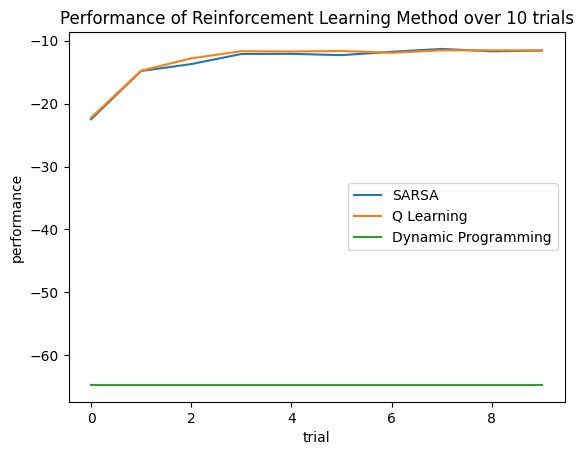

In [ ]:
def main():
    x, S_perf, Q_perf=TD()
    #policy, _, _ = monte_carlo_control()  # Learn the policy using Monte Carlo
   # MC_perf = [-evaluate_policy(policy) for _ in range(10)]  # Evaluate performance for Monte Carlo
    DP_perf =[-64.72 for i in range(10)]#get performance for DP

    plt.plot( x, S_perf, label="SARSA")
    plt.plot( x, Q_perf, label="Q Learning")
    #plt.plot( x, MC_perf, label="Monte Carlo")
    plt.plot( x, DP_perf, label="Dynamic Programming")
    plt.xlabel("trial")
    plt.ylabel("performance")
    plt.title("Performance of Reinforcement Learning Method over 10 trials")
    plt.legend()
    plt.show()

main()